In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzf -

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x


class ConvBlock11(nn.Module):

  def __init__(self):
    super(ConvBlock11, self).__init__()

    self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
    self.batch_norm1 = nn.BatchNorm3d(32)
    self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm2 = nn.BatchNorm3d(16)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm3 = nn.BatchNorm3d(8)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

  def forward(self, x):

    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

    return x


class FullNetwork11(nn.Module):

  def __init__(self, encoder, num_classes=3):
    super(FullNetwork11, self).__init__()

    self.encoder = encoder

    for param in list(self.encoder.parameters()):
        param.requires_grad = False

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
    self.batch_norm_fc = nn.BatchNorm1d(12)
    self.fc2 = nn.Linear(12, num_classes)

  def forward(self, x):

    x = self.encoder(x)

    x = self.flatten(x)
    x = F.relu(self.batch_norm_fc(self.fc1(x)))
    x = self.fc2(x)

    return x


In [ ]:
from torchsummary import summary

In [ ]:
encoder = ConvBlock11()
summary(FullNetwork11(encoder), (1, 182, 182, 218))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
       BatchNorm3d-2       [-1, 32, 37, 37, 44]              64
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
       BatchNorm3d-5       [-1, 16, 18, 18, 22]              32
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
       BatchNorm3d-8          [-1, 8, 9, 9, 11]              16
         MaxPool3d-9           [-1, 8, 4, 4, 5]               0
      ConvBlock11-10           [-1, 8, 4, 4, 5]               0
          Flatten-11                  [-1, 640]               0
           Linear-12                   [-1, 12]           7,692
      BatchNorm1d-13                   [-1, 12]              24
           Linear-14                   

In [ ]:
model = None
del model

## dataset creation

In [ ]:
import pandas as pd

tuning_df = pd.read_csv('ADNI3_tune.csv').drop('Unnamed: 0', axis=1)
testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
## if two classes:
tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)

train_df = tuning_df[tuning_df['Subject'].isin(train_subjects)][['Image Data ID','Group','Subject']]
train_images, train_labels, train_subjects = train_df.T.to_numpy()

valid_df = tuning_df[tuning_df['Subject'].isin(valid_subjects)][['Image Data ID','Group','Subject']]
valid_images, valid_labels, valid_subjects = valid_df.T.to_numpy()

In [ ]:
import re

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [ ]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

train_set = list(zip(train_images, train_labels))

train_set = list(filter(image_exists, train_set))

train_images, train_labels = zip(*train_set)

In [ ]:
train_image_paths = [id_to_path[k] for k in train_images]

In [ ]:
valid_set = list(zip(valid_images, valid_labels))

valid_set = list(filter(image_exists, valid_set))

valid_images, valid_labels = zip(*valid_set)

In [ ]:
valid_image_paths = [id_to_path[k] for k in valid_images]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Assuming the data is in a reasonable range, you may normalize it
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)


y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CNNDataset(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CNNDataset(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 32
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
n_classes

3

In [ ]:
len(train_loader)

57

In [ ]:
len(valid_loader)

7

## loading the pretrained convolutional layer

In [ ]:
!cp /content/drive/MyDrive/Main_Data/Checkpoints3/part2/Auto3dCNN11_ppmi.pth .

In [ ]:
autoencoder = Auto3dCNN11()

filename = 'Auto3dCNN11_ppmi.pth'

if not torch.cuda.is_available():
  checkpoint = torch.load(filename, map_location=torch.device('cpu'))
else:
  checkpoint = torch.load(filename)

autoencoder.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

In [ ]:
import re

encoder_dict = autoencoder.encoder.state_dict()

new_encoder_dict = {}
for k,v in encoder_dict.items():
  layer = int(re.search('\d+', k).group(0)) // 3 + 1
  part = re.search('\..*', k).group(0)
  new_encoder_dict[f'conv{layer}{part}'] = v


In [ ]:
conv_block = ConvBlock11()

conv_block.load_state_dict(new_encoder_dict, strict=False)

_IncompatibleKeys(missing_keys=['batch_norm1.weight', 'batch_norm1.bias', 'batch_norm1.running_mean', 'batch_norm1.running_var', 'batch_norm2.weight', 'batch_norm2.bias', 'batch_norm2.running_mean', 'batch_norm2.running_var', 'batch_norm3.weight', 'batch_norm3.bias', 'batch_norm3.running_mean', 'batch_norm3.running_var'], unexpected_keys=[])

In [ ]:
model = FullNetwork11(encoder=conv_block)

In [ ]:
import os, shutil, re

def prepare_model(filename="Auto3dCNN11_ppmi.pth", num_classes=2):

  if not os.path.isfile(filename):
    shutil.copy(f'/content/drive/MyDrive/Main_Data/Checkpoints3/part2/{filename}', filename)

  autoencoder = Auto3dCNN11()

  if not torch.cuda.is_available():
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(filename)

  autoencoder.load_state_dict(checkpoint['model_state_dict'], strict=False)

  encoder_dict = autoencoder.encoder.state_dict()

  new_encoder_dict = {}
  for k,v in encoder_dict.items():
    layer = int(re.search('\d+', k).group(0)) // 3 + 1
    part = re.search('\..*', k).group(0)
    new_encoder_dict[f'conv{layer}{part}'] = v

  conv_block = ConvBlock11()

  conv_block.load_state_dict(new_encoder_dict, strict=False)

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(encoder=conv_block, num_classes=num_classes)
  else:
    raise Exception('you should only use 2 or 3 classes for your model.')

  return model

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints3/part2' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = '3c_transfer_fullnetwork11_adni3.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = prepare_model(num_classes=3)
model.to(device)

# Number of training epochs
num_epochs = 30

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.75, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break

Epoch 0:


  0%|          | 0/57 [00:00<?, ?it/s]

Training Loss: 1.1550
Training Accuracy: 35.17%
Training F1-Score: 38.29%
           AD        CN       MCI
AD   0.338983  0.449153  0.211864
CN   0.295099  0.466111  0.238790
MCI  0.384196  0.411444  0.204360


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.3828
Validation Accuracy: 21.56%
Validation F1-Score: 22.36%
           AD        CN       MCI
AD   0.947368  0.000000  0.052632
CN   0.693069  0.217822  0.089109
MCI  0.816327  0.112245  0.071429
Epoch 0: SGD lr 0.000020 -> 0.000020
Epoch 0: saving...
Epoch 1:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1333
Training Accuracy: 34.90%
Training F1-Score: 37.98%
           AD        CN       MCI
AD   0.364407  0.432203  0.203390
CN   0.313869  0.471324  0.214807
MCI  0.403270  0.410082  0.186649


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1809
Validation Accuracy: 27.98%
Validation F1-Score: 31.15%
           AD        CN       MCI
AD   0.315789  0.473684  0.210526
CN   0.356436  0.336634  0.306931
MCI  0.459184  0.326531  0.214286
Epoch 1: SGD lr 0.000020 -> 0.000020
Epoch 1: saving...
Epoch 2:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1162
Training Accuracy: 37.49%
Training F1-Score: 40.63%
           AD        CN       MCI
AD   0.381356  0.364407  0.254237
CN   0.291971  0.505735  0.202294
MCI  0.403270  0.393733  0.202997


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1719
Validation Accuracy: 28.90%
Validation F1-Score: 31.38%
           AD        CN       MCI
AD   0.368421  0.473684  0.157895
CN   0.326733  0.356436  0.316832
MCI  0.438776  0.357143  0.204082
Epoch 2: SGD lr 0.000020 -> 0.000020
Epoch 2: saving...
Epoch 3:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1016
Training Accuracy: 39.37%
Training F1-Score: 42.21%
           AD        CN       MCI
AD   0.423729  0.372881  0.203390
CN   0.285714  0.523462  0.190824
MCI  0.371935  0.408719  0.219346


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1582
Validation Accuracy: 30.28%
Validation F1-Score: 32.26%
           AD        CN       MCI
AD   0.315789  0.473684  0.210526
CN   0.277228  0.396040  0.326733
MCI  0.387755  0.408163  0.204082
Epoch 3: SGD lr 0.000020 -> 0.000019
Epoch 3: saving...
Epoch 4:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0908
Training Accuracy: 40.53%
Training F1-Score: 43.25%
           AD        CN       MCI
AD   0.406780  0.372881  0.220339
CN   0.261731  0.546403  0.191867
MCI  0.378747  0.400545  0.220708


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1474
Validation Accuracy: 33.03%
Validation F1-Score: 35.41%
           AD        CN       MCI
AD   0.315789  0.473684  0.210526
CN   0.257426  0.425743  0.316832
MCI  0.397959  0.367347  0.234694
Epoch 4: SGD lr 0.000019 -> 0.000019
Epoch 4: saving...
Epoch 5:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0828
Training Accuracy: 41.25%
Training F1-Score: 44.14%
           AD        CN       MCI
AD   0.449153  0.347458  0.203390
CN   0.263816  0.531804  0.204380
MCI  0.355586  0.393733  0.250681


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1413
Validation Accuracy: 33.49%
Validation F1-Score: 35.77%
           AD        CN       MCI
AD   0.315789  0.473684  0.210526
CN   0.237624  0.425743  0.336634
MCI  0.387755  0.367347  0.244898
Epoch 5: SGD lr 0.000019 -> 0.000019
Epoch 5: saving...
Epoch 6:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0726
Training Accuracy: 43.29%
Training F1-Score: 46.35%
           AD        CN       MCI
AD   0.406780  0.322034  0.271186
CN   0.255474  0.555787  0.188738
MCI  0.333787  0.389646  0.276567


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1381
Validation Accuracy: 36.24%
Validation F1-Score: 38.00%
           AD        CN       MCI
AD   0.315789  0.473684  0.210526
CN   0.207921  0.495050  0.297030
MCI  0.377551  0.387755  0.234694
Epoch 6: SGD lr 0.000019 -> 0.000019
Epoch 6: saving...
Epoch 7:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0677
Training Accuracy: 44.34%
Training F1-Score: 46.88%
           AD        CN       MCI
AD   0.483051  0.322034  0.194915
CN   0.235662  0.566215  0.198123
MCI  0.326975  0.396458  0.276567


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1367
Validation Accuracy: 33.49%
Validation F1-Score: 35.64%
           AD        CN       MCI
AD   0.368421  0.421053  0.210526
CN   0.257426  0.415842  0.326733
MCI  0.377551  0.377551  0.244898
Epoch 7: SGD lr 0.000019 -> 0.000019
Epoch 7: saving...
Epoch 8:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0570
Training Accuracy: 46.38%
Training F1-Score: 49.04%
           AD        CN       MCI
AD   0.457627  0.322034  0.220339
CN   0.227320  0.589155  0.183525
MCI  0.311989  0.386921  0.301090


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1370
Validation Accuracy: 35.78%
Validation F1-Score: 38.21%
           AD        CN       MCI
AD   0.526316  0.210526  0.263158
CN   0.257426  0.415842  0.326733
MCI  0.428571  0.306122  0.265306
Epoch 8: SGD lr 0.000019 -> 0.000019
Epoch 8: saving...
Epoch 9:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0492
Training Accuracy: 45.61%
Training F1-Score: 48.22%
           AD        CN       MCI
AD   0.474576  0.288136  0.237288
CN   0.228363  0.573514  0.198123
MCI  0.309264  0.391008  0.299728


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1215
Validation Accuracy: 37.16%
Validation F1-Score: 38.78%
           AD        CN       MCI
AD   0.315789  0.473684  0.210526
CN   0.198020  0.485149  0.316832
MCI  0.326531  0.408163  0.265306
Epoch 9: SGD lr 0.000019 -> 0.000018
Epoch 9: saving...
Epoch 10:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0428
Training Accuracy: 48.09%
Training F1-Score: 50.53%
           AD        CN       MCI
AD   0.491525  0.271186  0.237288
CN   0.212722  0.602711  0.184567
MCI  0.292916  0.386921  0.320163


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1362
Validation Accuracy: 34.86%
Validation F1-Score: 36.53%
           AD        CN       MCI
AD   0.526316  0.210526  0.263158
CN   0.247525  0.425743  0.326733
MCI  0.397959  0.367347  0.234694
Epoch 10: SGD lr 0.000018 -> 0.000018
Epoch 10: saving...
Epoch 11:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0373
Training Accuracy: 49.36%
Training F1-Score: 51.36%
           AD        CN       MCI
AD   0.491525  0.279661  0.228814
CN   0.198123  0.625652  0.176225
MCI  0.272480  0.405995  0.321526


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1312
Validation Accuracy: 36.24%
Validation F1-Score: 37.30%
           AD        CN       MCI
AD   0.421053  0.368421  0.210526
CN   0.227723  0.504950  0.267327
MCI  0.377551  0.418367  0.204082
Epoch 11: SGD lr 0.000018 -> 0.000018
Epoch 11: saving...
Epoch 12:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0279
Training Accuracy: 50.52%
Training F1-Score: 52.58%
           AD        CN       MCI
AD   0.457627  0.296610  0.245763
CN   0.190824  0.624609  0.184567
MCI  0.239782  0.403270  0.356948


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1137
Validation Accuracy: 38.99%
Validation F1-Score: 40.24%
           AD        CN       MCI
AD   0.315789  0.421053  0.263158
CN   0.178218  0.534653  0.287129
MCI  0.326531  0.418367  0.255102
Epoch 12: SGD lr 0.000018 -> 0.000018
Epoch 12: saving...
Epoch 13:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0238
Training Accuracy: 49.70%
Training F1-Score: 51.62%
           AD        CN       MCI
AD   0.483051  0.262712  0.254237
CN   0.191867  0.621481  0.186653
MCI  0.252044  0.411444  0.336512


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1050
Validation Accuracy: 38.07%
Validation F1-Score: 39.15%
           AD        CN       MCI
AD   0.368421  0.368421  0.263158
CN   0.178218  0.475248  0.346535
MCI  0.265306  0.448980  0.285714
Epoch 13: SGD lr 0.000018 -> 0.000018
Epoch 13: saving...
Epoch 14:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0188
Training Accuracy: 51.57%
Training F1-Score: 53.73%
           AD        CN       MCI
AD   0.466102  0.296610  0.237288
CN   0.187696  0.635036  0.177268
MCI  0.245232  0.386921  0.367847


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1122
Validation Accuracy: 38.53%
Validation F1-Score: 39.41%
           AD        CN       MCI
AD   0.263158  0.473684  0.263158
CN   0.168317  0.524752  0.306931
MCI  0.265306  0.469388  0.265306
Epoch 14: SGD lr 0.000018 -> 0.000018
Epoch 14: saving...
Epoch 15:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0109
Training Accuracy: 52.79%
Training F1-Score: 54.59%
           AD        CN       MCI
AD   0.423729  0.288136  0.288136
CN   0.161627  0.656934  0.181439
MCI  0.230245  0.393733  0.376022


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1035
Validation Accuracy: 40.37%
Validation F1-Score: 40.33%
           AD        CN       MCI
AD   0.263158  0.473684  0.263158
CN   0.128713  0.574257  0.297030
MCI  0.234694  0.510204  0.255102
Epoch 15: SGD lr 0.000018 -> 0.000017
Epoch 15: saving...
Epoch 16:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0059
Training Accuracy: 52.18%
Training F1-Score: 53.90%
           AD        CN       MCI
AD   0.449153  0.296610  0.254237
CN   0.174140  0.649635  0.176225
MCI  0.222071  0.411444  0.366485


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1076
Validation Accuracy: 38.53%
Validation F1-Score: 39.40%
           AD        CN       MCI
AD   0.263158  0.473684  0.263158
CN   0.158416  0.514851  0.326733
MCI  0.255102  0.469388  0.275510
Epoch 16: SGD lr 0.000017 -> 0.000017
Epoch 16: saving...
Epoch 17:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0003
Training Accuracy: 53.62%
Training F1-Score: 55.27%
           AD        CN       MCI
AD   0.449153  0.245763  0.305085
CN   0.153285  0.656934  0.189781
MCI  0.213896  0.393733  0.392371


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1062
Validation Accuracy: 38.53%
Validation F1-Score: 39.07%
           AD        CN       MCI
AD   0.368421  0.368421  0.263158
CN   0.178218  0.524752  0.297030
MCI  0.275510  0.479592  0.244898
Epoch 17: SGD lr 0.000017 -> 0.000017
Epoch 17: saving...
Epoch 18:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9963
Training Accuracy: 53.51%
Training F1-Score: 55.29%
           AD        CN       MCI
AD   0.398305  0.305085  0.296610
CN   0.168926  0.654849  0.176225
MCI  0.194823  0.404632  0.400545


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1106
Validation Accuracy: 38.07%
Validation F1-Score: 38.89%
           AD        CN       MCI
AD   0.368421  0.368421  0.263158
CN   0.158416  0.514851  0.326733
MCI  0.316327  0.438776  0.244898
Epoch 18: SGD lr 0.000017 -> 0.000017
Epoch 18: saving...
Epoch 19:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9882
Training Accuracy: 55.38%
Training F1-Score: 57.01%
           AD        CN       MCI
AD   0.423729  0.288136  0.288136
CN   0.151199  0.671533  0.177268
MCI  0.190736  0.388283  0.420981


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0994
Validation Accuracy: 39.91%
Validation F1-Score: 39.41%
           AD        CN       MCI
AD   0.210526  0.526316  0.263158
CN   0.108911  0.594059  0.297030
MCI  0.234694  0.530612  0.234694
Epoch 19: SGD lr 0.000017 -> 0.000017
Epoch 19: saving...
Epoch 20:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9818
Training Accuracy: 55.33%
Training F1-Score: 56.71%
           AD        CN       MCI
AD   0.415254  0.271186  0.313559
CN   0.139729  0.686131  0.174140
MCI  0.198910  0.399183  0.401907


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0958
Validation Accuracy: 40.37%
Validation F1-Score: 42.07%
           AD        CN       MCI
AD   0.315789  0.315789  0.368421
CN   0.158416  0.475248  0.366337
MCI  0.275510  0.377551  0.346939
Epoch 20: SGD lr 0.000017 -> 0.000017
Epoch 20: saving...
Epoch 21:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9797
Training Accuracy: 55.22%
Training F1-Score: 56.66%
           AD        CN       MCI
AD   0.398305  0.296610  0.305085
CN   0.148071  0.680918  0.171011
MCI  0.186649  0.404632  0.408719


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0956
Validation Accuracy: 38.53%
Validation F1-Score: 39.42%
           AD        CN       MCI
AD   0.263158  0.473684  0.263158
CN   0.148515  0.514851  0.336634
MCI  0.265306  0.459184  0.275510
Epoch 21: SGD lr 0.000017 -> 0.000016
Epoch 21: saving...
Epoch 22:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9720
Training Accuracy: 56.54%
Training F1-Score: 57.75%
           AD        CN       MCI
AD   0.415254  0.305085  0.279661
CN   0.135558  0.697602  0.166840
MCI  0.179837  0.403270  0.416894


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1044
Validation Accuracy: 38.53%
Validation F1-Score: 38.79%
           AD        CN       MCI
AD   0.263158  0.473684  0.263158
CN   0.128713  0.534653  0.336634
MCI  0.244898  0.500000  0.255102
Epoch 22: SGD lr 0.000016 -> 0.000016
Epoch 22: saving...
Epoch 23:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9612
Training Accuracy: 57.21%
Training F1-Score: 58.43%
           AD        CN       MCI
AD   0.449153  0.296610  0.254237
CN   0.128259  0.699687  0.172054
MCI  0.186649  0.388283  0.425068


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1003
Validation Accuracy: 40.37%
Validation F1-Score: 41.80%
           AD        CN       MCI
AD   0.315789  0.315789  0.368421
CN   0.158416  0.504950  0.336634
MCI  0.275510  0.408163  0.316327
Epoch 23: SGD lr 0.000016 -> 0.000016
Epoch 23: saving...
Epoch 24:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9593
Training Accuracy: 57.04%
Training F1-Score: 58.16%
           AD        CN       MCI
AD   0.398305  0.288136  0.313559
CN   0.122002  0.702815  0.175182
MCI  0.178474  0.396458  0.425068


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0959
Validation Accuracy: 42.20%
Validation F1-Score: 42.01%
           AD        CN       MCI
AD   0.210526  0.526316  0.263158
CN   0.099010  0.594059  0.306931
MCI  0.204082  0.510204  0.285714
Epoch 24: SGD lr 0.000016 -> 0.000016
Epoch 24: saving...
Epoch 25:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9550
Training Accuracy: 58.03%
Training F1-Score: 59.10%
           AD        CN       MCI
AD   0.423729  0.288136  0.288136
CN   0.120959  0.712200  0.166840
MCI  0.174387  0.392371  0.433243


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0989
Validation Accuracy: 41.74%
Validation F1-Score: 42.62%
           AD        CN       MCI
AD   0.263158  0.368421  0.368421
CN   0.128713  0.514851  0.356436
MCI  0.204082  0.448980  0.346939
Epoch 25: SGD lr 0.000016 -> 0.000016
Epoch 25: saving...
Epoch 26:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9521
Training Accuracy: 58.59%
Training F1-Score: 59.36%
           AD        CN       MCI
AD   0.423729  0.288136  0.288136
CN   0.114703  0.722628  0.162669
MCI  0.158038  0.408719  0.433243


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0995
Validation Accuracy: 40.83%
Validation F1-Score: 41.66%
           AD        CN       MCI
AD   0.263158  0.421053  0.315789
CN   0.128713  0.534653  0.336634
MCI  0.244898  0.448980  0.306122
Epoch 26: SGD lr 0.000016 -> 0.000016
Epoch 26: saving...
Epoch 27:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9425
Training Accuracy: 59.58%
Training F1-Score: 60.59%
           AD        CN       MCI
AD   0.406780  0.322034  0.271186
CN   0.117831  0.725756  0.156413
MCI  0.158038  0.385559  0.456403


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0983
Validation Accuracy: 40.83%
Validation F1-Score: 41.60%
           AD        CN       MCI
AD   0.315789  0.421053  0.263158
CN   0.138614  0.514851  0.346535
MCI  0.224490  0.459184  0.316327
Epoch 27: SGD lr 0.000016 -> 0.000015
Epoch 27: saving...
Epoch 28:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9433
Training Accuracy: 59.03%
Training F1-Score: 59.98%
           AD        CN       MCI
AD   0.398305  0.338983  0.262712
CN   0.113660  0.715328  0.171011
MCI  0.152589  0.389646  0.457766


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0889
Validation Accuracy: 42.20%
Validation F1-Score: 43.00%
           AD        CN       MCI
AD   0.210526  0.421053  0.368421
CN   0.128713  0.524752  0.346535
MCI  0.183673  0.459184  0.357143
Epoch 28: SGD lr 0.000015 -> 0.000015
Epoch 28: saving...
Epoch 29:


  0%|          | 0/57 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9326
Training Accuracy: 60.80%
Training F1-Score: 61.43%
           AD        CN       MCI
AD   0.440678  0.254237  0.305085
CN   0.096976  0.736184  0.166840
MCI  0.143052  0.389646  0.467302


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0844
Validation Accuracy: 44.04%
Validation F1-Score: 43.87%
           AD        CN       MCI
AD   0.210526  0.473684  0.315789
CN   0.079208  0.574257  0.346535
MCI  0.142857  0.510204  0.346939
Epoch 29: SGD lr 0.000015 -> 0.000015
Epoch 29: saving...


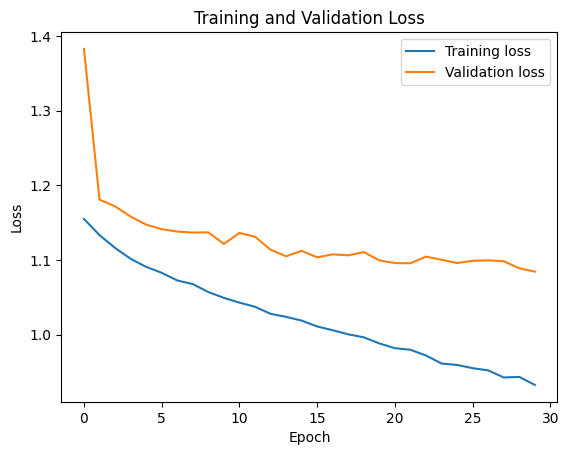

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()